# MesoNet 

MesoNet can be used either through a GUI or the command line interface (CLI). This notebook will make use of the CLI. 

MesoNet can be used for two main alignment types:

ATLAS -> BRAIN: 
- Given a pre-trained DeepLabCut model that was trained to associate anatomical landmarks with corresponding points on atlases of brain regions, this approach registers an atlas of brain regions to the fixed brain imaging data using affine transformations. This approach is useful if your data has common anatomical landmarks and is the most robust to variations in image quality and orientation within your data.
- re-scales a reference atlas to fit brain data for regional anaysis of brain activity 

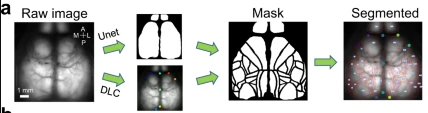

BRAIN -> ATLAS:
- Given a pre-trained DeepLabCut model that was trained to associate anatomical landmarks with corresponding points on atlases of brain regions, the brain imaging data is fixed onto an atlas of brain regions using affine transformations. This approach is useful if you would like to normalize your brain images to a common template based on anatomical landmarks.
- scales each brain to a common reference atlas with predicted landmarks 

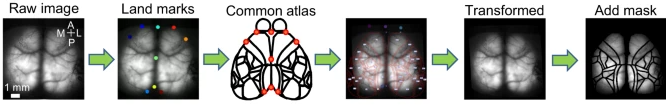


In [1]:
# make sure to activate your DEEPLABCUT environment before processing any data. 
!conda activate DEEPLABCUT

In [2]:
# set verbose to True if you want to get feedback from each cell
verbose = True

In [3]:
# import all necessary modules

import mesonet
from data_loading_functions import *
import numpy as np
from datetime import datetime
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import matplotlib as mpl 
from PIL import Image
from tqdm import tqdm
import glob

Loading DLC 3.0.0rc3...


In [4]:
# helper function to remove an output directory. !! To be used for debugging !!

def remove_output_dir(dir_path): 
    '''
    dir_path is either the path to the main Data_outputs folder (to remove all subfolders)
    or the path to a single subfolder. 
    '''

    shutil.rmtree(dir_path)

    if not os.path.exists("Data_outputs"): os.makedirs("Data_outputs")

    if verbose: print(f"Successfully deleted the {dir_path} folder and its contents.")

    return None

# helper function to move .npy files from the input_dir directory into a np_files directory

def move_np_files(source_dir, target_dir):
    np_file_num = len(glob.glob((os.path.join(source_dir, '*.npy'))))

    # if there are no npy files, return funtion
    if np_file_num != 0:
        # check if a np_files directory exists. If not, make one
        if not os.path.exists(target_dir): os.makedirs(target_dir) 
        
        # iterate through all .npy files and move them to the target_dir
        [shutil.move(file, os.path.join(target_dir, os.path.basename(file))) for file in glob.glob(os.path.join(source_dir, '*.npy'))]
        
        return np_file_num
    else:
        return 0
    
# helper function to remove all .png files from input_dir directory. Used for debugging and testing

def remove_png_files(source_dir):
    files_to_remove = glob.glob(os.path.join(source_dir, '*.png'))
    file_num = len(files_to_remove)

    # Iterate through all .png files and remove them with a progress bar
    for im in tqdm(files_to_remove, desc="Removing .png images", unit="image"):
        os.remove(im)
    
    if verbose:
        print(f"Finished removing all {file_num} .png files from {source_dir}")

    return None

In [ ]:
#remove_output_dir("Data_outputs")
#remove_png_files("Data_inputs")

---
# Testing Data Preparation: 
### .dat or .npy --> .png

MesoNet requires that images be in an 8-bit (value 0-255) .png files in order to be used. 
The pipeline however currently allows a series of possible options. 

All input data for a single session / processing run must be in a single directory containing one of the following: 
1. a single .dat file
2. a series of .png brain images (may also contain a .dat file but NO .npy files)

An output directory within `Data_outputs` will be created with the current date and time in order to keep track of all processing. 

In [5]:
# add the path to the input and output directories as specified above
input_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_inputs"
output_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_outputs" # add the name of a specific folder if you want to name your own or if you want to use an existing one

# check if user wants a specific directory name for all outputs
if os.path.basename(output_dir) == "Data_outputs":
    # make a folder within the output_dir directory where we will keep track of all current outputs and config files for this run
    now = datetime.now()
    output_dir_w_time = os.path.join(output_dir, now.strftime("%Y-%m-%d_%H-%M"))
    os.makedirs(output_dir_w_time, exist_ok=True)

    output_dir = output_dir_w_time
else:
    os.makedirs(output_dir, exist_ok=True)
    
if verbose: print(f"New directory created: {output_dir} \nThis will be our output directory for the rest of the notebook.")

New directory created: C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_outputs\2024-08-08_15-39 
This will be our output directory for the rest of the notebook.


In [6]:
# our pipeline works with a stack of np arrays representing the wfield images.
# prepare the data as it would appear after coming out of the preprocessing pipeline.
# For this example, we will load only 500 of the original 10000+ brain images. 

# check if there are .png images already present in the Data_inputs folder.
if len(glob.glob(f"{input_dir}/*.png")) != 0: # there are images present
    if verbose: print("Make sure images are 8-bit (0-255 value) before proceeding.")

else: # There must be a .dat file
    # make a numpy array from the .dat file
    np_img_stack = load_dat_frames(filename=glob.glob(os.path.join(input_dir, '*.dat'))[0])
    if verbose: print(f"numpy stack successfully loaded from .dat file. It has shape: {np_img_stack.shape}.")

    # make sure the array is of correct dimension: we only want access to the blue frames (single channel)
    if len(np_img_stack.shape) == 4:
        if np_img_stack.shape[1] != 1:
            np_img_stack = np_img_stack[:,0,...]
        else: np_img_stack = np.squeeze(np_img_stack, axis=1)
    
    # TODO: remove the lightweight option when making full version of this code. 
    np_img_stack = np_img_stack[:5,...]

    # make sure all array is of type uint8 with values 0-255
    if np_img_stack.dtype == 'uint16':
        # normalize the values to be between 0-1
        normalized_stack = (np_img_stack - np.min(np_img_stack)) / (np.max(np_img_stack) - np.min(np_img_stack))
        # scale to range 0-255
        scaled_stack = normalized_stack * 255.0
        # convert to uint8
        np_img_stack = scaled_stack.astype(np.uint8)
        # TODO: remove this if necessary
        # Rotate images 180 degrees 
        np_img_stack = np_img_stack[:, ::-1, ::-1]

    
    # Convert the NumPy stack into a series of .png images with a progress bar
    for i, im in enumerate(tqdm(np_img_stack, desc="Saving images as .png", unit="image")):
        im_file_name = os.path.join(input_dir, f"frame{i}.png")
        Image.fromarray(im).save(im_file_name)
    
    if verbose: print(f"{i+1} .png files have been created in the {input_dir} directory.")


# make sure there are no .npy files in the Data_inputs directory as this will impact the MesoNet processing
np_file_num = move_np_files(input_dir, "np_files")
if verbose:
    if np_file_num > 0: print(f"{np_file_num} numpy files were moved from {input_dir} to the np_files directory.")



numpy stack successfully loaded from .dat file. It has shape: (2308, 2, 640, 540).


Saving images as .png: 100%|██████████| 5/5 [00:00<00:00, 19.80image/s]

5 .png files have been created in the C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_inputs directory.


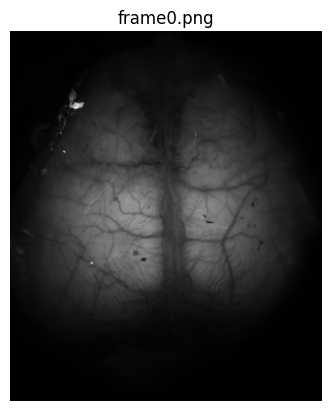

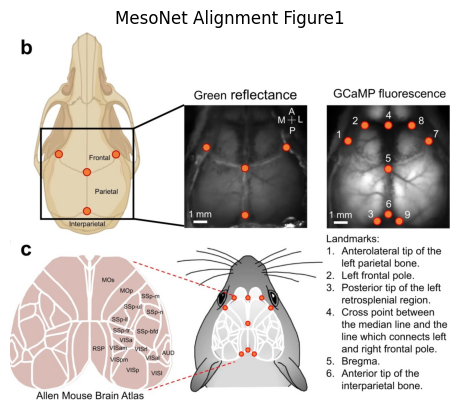

In [7]:
# visualize an image from the Data_inputs folder

img = mpimg.imread((glob.glob(f"{input_dir}/*.png"))[0])

plt.imshow(img, cmap='gray')
plt.axis('off') 
plt.title(os.path.basename(glob.glob(f"{input_dir}/*.png")[0]))
plt.show()

mesoNet_im = mpimg.imread(r"c:\Users\bbettl\PycharmProjects\MesoNet\img\mesonet.jpg")
plt.imshow(mesoNet_im)
plt.axis('off') 
plt.title("MesoNet Alignment Figure1")
plt.show()


---
# Introduction: MesoNet Models

[MesoNet paper](https://www.nature.com/articles/s41467-021-26255-2)

<ins>Landmark Estimation:</ins> 
- Based on the , 491 images annotated with nine anatomical landmarks were used to train a landmark estimation network via DeepLabCut. 
- "The average distance between the placement of our network and human annotators was generally around 0.1mm and not more than the difference ebtween human raters"

<ins>Cortex Boundary Delimitation:</ins>
- done using a trained and adapted U-Net network. 

<ins>Image Inpainting:</ins>
- "To determine whether the wide-field basal fluorescence pattern contains adequate structural information for landmark annotation, we employed an inpainting method to process the raw images and remove cortical-tissue independent patterns such as blood vessels. To generate masks of blood vessels on wide-field calcium images, we used an adaptive thresholding method implemented in OpenCV. Next, we used a Fast Marching Method algorithm58 to fill in the entire region, starting from the boundary of this region. The algorithm operates by taking a region of pixels around the pixel on the area to be inpainted, then replacing the original pixel by a normalized weighted sum of all the known pixels in the neighborhood of the pixels."

---
Default MesoNet models are from the OSF repository. 

- U-Net (.hdf5)
- VoxelMorph (.h5) 

All models need to be in a folder called `models` within the *mesonet* directory of the MesoNet git repo.

---
## Running & Using MestoNet Models: 

### Configuration files:

The configuration file is used to customize the MesoNet analysis. It is created in the `output_dir` location 
The full list of configuration parameters can be found [here](https://github.com/bf777/MesoNet/wiki/Config-File-Guide).


##### Model Training params of interest: 

- <ins>**epochs**</ins> default 60: The number of epochs for which the model will be trained. You may wish to reduce this number if you're updating an existing model.

- <ins>**log_folder**</ins> folder to which logging data should be output (and where this config file will be saved)

- <ins>**steps_per_epoch**</ins> default 300: The number of steps per training epoch. Influences the pace at which the model is trained.



##### Model Testing params of interest: 

- <ins>**model**</ins> location (within the MesoNet repository) of a U-Net model to be used for finding the boundaries of the brain region (as the default model does), or (if you have a specially trained model for this purpose) segmenting the entire brain into regions without the need for atlas alignment. Only choose another model if you have another model that you would like to use for segmenting the brain.

- <ins>**threshold**</ins> adjusts the sensitivity of the algorithm used to define individual brain regions from the brain atlas. Changing this number may significantly change the quality of the brain region predictions
    - increasing this number causes each brain region contour to be smaller (less like the brain atlas)
    - decreasing this number causes each brain region contour to be larger (more like the brain atlas).

- <ins>**olfactory_check**</ins> when True, draws olfactory bulb contours on brain image

- <ins>**align_once**</ins> if True, carries out all alignments based on the alignment of the first atlas and brain. This can save time if you have many frames of the same brain with a fixed camera position.

- <ins>**atlas_label_list**</ins> list of aligned atlases in which each brain region is filled with a unique numeric label. Allows for consistent identification of brain regions across images. If original_label is True, this is an empty list.

- <ins>**landmark_arr**</ins> The default number and order of landmarks to be used for the full alignment of a standard brain atlas to a brain image. Change what is contained in this list to change the landmarks used. When the default DeepLabCut model with nine landmarks, the landmarks are
    - 0: Anterolateral tip of the left parietal bone.
    - 1: Left frontal pole.
    - 2: Posterior tip of the left retrosplenial region.
    - 3: Cross point between the median line and the line which connects the left and right frontal pole.
    - 4: Bregma (centre point of cortex)
    - 5: Anterior tip of the interparietal bone.
    - 6: Anterolateral tip of the right parietal bone.
    - 7: Right frontal pole.
    - 8: Posterior tip of the right retrosplenial region.

---
# Testing Data Prep

In order to train our existing U-net model, we need to collect a series of wfield images and prepare them for training. 
This involves annotating each image. 

As of August 7th 2024, we will be adding a batch of 20 images. 
In this first trial, these will be taken from a total of 4 different wfield sessions (four different days) collected from two different mice as part of Nicole's experiment.   

In [ ]:
# create a function to convert a series of .dat files into a training dataset consisting of >= 20 .png w-field images. 
# THE .PNG FILES MUST BE OF THE FORMAT i.png WITH i RANGING FROM 0 TO train_set_length. 

def create_our_train_set(save_path, data_path_list, train_set_length=20):
    '''
    function takes as input 
        - output_path: path of directory location, in which to store new training set. If file location does not exist, it will be created. Otherwise, it will be overwritten
        - data_path_list: a list of any number of .dat file paths from which to create training dataset
        - train_set_length: number >=20 (ideally) representing the number of training images to create
    ''' 

    # check if output_path exists. If not, create the directory
    os.makedirs(save_path, exist_ok=True)

    # determine the number of images to take from each .dat file
    dat_file_num = len(data_path_list)

    per_file_num = int(np.ceil(train_set_length / dat_file_num))

    # convert each .dat into a numpy array 
    
    #for i, im in enumerate(tqdm(np_img_stack, desc="Saving images as .png", unit="image"))
    im_counter = 0 
    for current_path in tqdm(data_path_list, desc="Creating and saving .png training images", unit="data file"):
        curr_data_array = load_dat_frames(current_path)

        if len(curr_data_array.shape) != 3: 
            if curr_data_array.shape[1] == 2: # np array still has two channels
                # take only the blue channel
                curr_data_array = curr_data_array[:,0,...]
            else:
                curr_data_array = np.squeeze(curr_data_array, axis=1)
        
        # rotate the images 180 degrees
        curr_data_array = curr_data_array[:, ::-1, ::-1]

        indices = np.linspace(0, len(curr_data_array[0]) - 1, per_file_num).astype(int)
        
        # extract the desired number of images from each array
        for i in indices:
            im_file_name = os.path.join(save_path, f"{im_counter}.png")
            
            curr_im_array = curr_data_array[i]

            # make sure array is of type uint8 with values 0-255
            if curr_im_array.dtype == 'uint16':
                # normalize the values to be between 0-1
                normalized_stack = (curr_im_array - np.min(curr_im_array)) / (np.max(curr_im_array) - np.min(curr_im_array))
                # scale to range 0-255
                scaled_stack = normalized_stack * 255.0
                # convert to uint8
                curr_im_array = scaled_stack.astype(np.uint8)
            
            # save these images into the output_path
            Image.fromarray(curr_im_array).save(im_file_name)
            im_counter += 1
                    
    if verbose: print(f"Done creating {train_set_length} training images from the {dat_file_num} files.")


In [ ]:
#remove_png_files("training_images_Aug_7")

In [ ]:
save_path = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\training_images_Aug_7"
data_path_list = [r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\temp_data\Frames_2_640_540_uint16_train0.dat", r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\temp_data\Frames_2_640_540_uint16_train1.dat"]

create_our_train_set(save_path, data_path_list, 10)


Now that the training set has been initialized, we need to manually create the corresponding training masks and DLC points. 

We will do this with the help of the MesoNet GUI. 

<ins>STEPS:
1. open a `command prompt` terminal 
2. type the following in subsequent lines of the cmd terminal

> conda activate DEEPLABCUT

You should now see `(DEEPLABCUT)` on the left of every line in the cmd terminal.

> ipython

> import mesonet

> mesonet.gui_start('train')


<ins> Within the MesoNet Train GUI

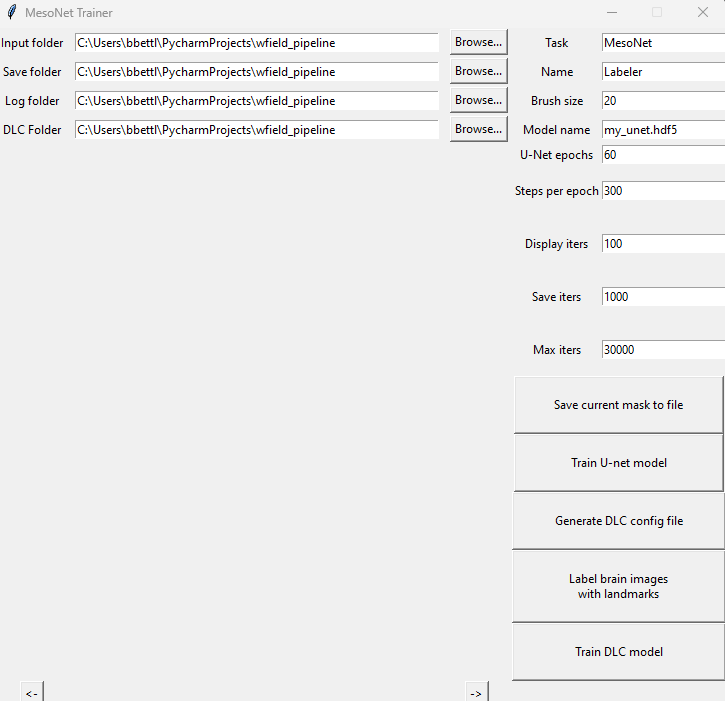

### Creating Training Masks: 

On the left side of the MesoNet Trainer GUI 
1. Select the proper input folder path (path to the training dataset we just created)
2. Select the proper save folder path (path to a dir where our brain images and masks for training the model will be saved)
3. Select the proper log folder path (path to a dir where we want to record the output data from the U-Net model)
4. Select the proper DLC folder path (path to a dir where we want to save the DeepLabCut project)

Ignore the right side of the MesoNet Trainer GUI for now. 

We will now focus on the images that have now appeared on the GUI screen. 

5. Paint in the cortical region on the brain image
    - You can adjust the brush size for the painting (in pixels) by changing the value next to "Brush Size" in the top right part of the window. 
    - Click and drag on the image where you want to paint the cortical region (white pixels)
    - Once you're finished, click "Save current mask to file". This will save your painted region against a black background into a `label` subfolder of the directory you chose in "Save folder". 
    - A copy of the original image will also be saved into a corresponding `image` subfolder. 
    - Go through each image using the left and right arrow keys or the arrow buttons at the bottom of the screen, painting in the cortical region and clicking "Save current mask to file" each time. 
    
    ** *If you want to repaint an image, you can return to that image and paint it over again; saving it again will overwrite the original image.**

**The Image masks have now been created and are located in the save folder specified in the GUI and in step 2.**
**You will not have to draw the masks again (you may now close the GUI window). These steps do NOT need to be repeated now that it has been completed once with these training images.**

### Train U-Net 
<ins> Within the MesoNet Train GUI 
* can be the same window as above or a new one. 

On the right side of the MesoNet Trainer GUI

6. Model Name: name your model by selecting the name of an existing model you wish to retrain 
    - make sure the name ends with `.hdf5`
    - if the model name already exists in the MesoNet git repo, the existing model will be trained with the data provided (online training) rather than training a new model. 
7. Change the following params as necessary:
    - epochs: number of epochs for which model will run
    - steps_per_epoch: number of steps per training epoch 
    - display iters: 
    - save iters: number of iterations to log into the log file 
    - max iters: 

8. click on `Train U-Net model" to train U-Net model 

### Label Landmarks on Training Images

<ins> Within the MesoNet Train GUI
* can be the same window as above or a new one

9. Name: Add your name as the labeler's name
10. Click "generate DLC config file" to generate new folder (within the DLC folder path) where DLC computations take place
    - folder will be of the following format: `Task-Labeler-YYYY-MM-DD`
11. Click Label brain images with landmakrs"
    - you will be taken to DEEPLABCUT's interface. 
    - you may have to type yes in the command line 



---
## Model Training:

1. Online training 
2. Data augmentation algorithm 
    - add additional image-mask pairs to an existing model and train existing model with these additional images. 
    - uses Keras's data augmentation feature 

### U-Net
The U-Net model will delimit the boundary of the cortex visible in the brain image. As such, in order to train this model, you will need to pair each input brain image with a drawing where the cortex is white and everything outside the cortex is black. Our GUI provides you with an interface to create and save these drawings alongside the original input brain images.

### DeepLabCut
The DeepLabCut model will locate nine cortical landmarks based on your labelling these landmarks in a set of brain images. Our GUI helps you prepare the DeepLabCut project, guides you into DeepLabCut's labelling GUI, and trains the DeepLabCut model based on these labels.


We will be using the same `input_dir` and `output_dir` variables as previously loaded. Make sure these are correctly intiialized before proceeding. 

## Preparation
For best results, please make sure that all of your brain images are 8-bit, and in .png format.

**GUI method**: Place all of your brain images in a single directory.

**Command line interface method**: For each image that you wish to use in your training set, create a binary mask where the whole cortical region is filled in white and the rest of the picture is filled in black. Put the brain images in a folder called `image`, and put the masks in a folder called `label`. Put both of these folders together in a single folder, which you'll use as your input folder.


---

"For "DLC config folder", if you are using your own DeepLabCut model to identify landmarks on the mouse cortex, locate the config.yaml file for that model here. Otherwise, the system will use a default model included with MesoNet (at the path shown in the box at "DLC config folder" when you start up MesoNet). IMPORTANT: for this step to work, you must navigate in the MesoNet repository to `mesonet/dlc/config.yaml`, and change the file paths after `project_path` and `video_sets` to the path to the displayed folder _on your own computer_. **NOTE: you will likely have to change the path here to find a config.yaml file for the model you wish to use!**
"

`model_name`: (optional) Set a new name for the unet model to be trained. Default is 'unet.hdf5' .

`config`: Select the config file for the DeepLabCut model to be used for landmark estimation. 

`atlas`:  Set to True to just predict the cortical landmarks on your brain images, and not segment your brain images by region. Upon running mesonet.predict_dlc(config_file), MesoNet will output your brain images  labelled with these landmarks as well as a file with the coordinates of these landmarks. Set to False to carry out the full brain image segmentation workflow. 

`use_dlc`: Choose whether or not to try and register the atlas and brain image using a DeepLabCut model.

`atlas_to_brain_align`: If True, registers the atlas to each brain image. If False, registers each brain image to the atlas. 

`plot_landmarks`: If True, plots DeepLabCut landmarks (large circles) and original alignment landmarks (small  circles) on final brain image. 

`align_once`: if True, carries out all alignments based on the alignment of the first atlas and brain. This can save time if you have many frames of the same brain with a fixed camera position.

`model`: The location (within the MesoNet repository) of a U-Net model to be used for finding the boundaries  of the brain region (as the default model does), or (if you have a specially trained model for this purpose) segmenting the entire brain into regions without the need for atlas alignment. Only choose another model if you have  another model that you would like to use for segmenting the brain.

In [ ]:
model_name = f'{datetime.date}_testModelUnet.hdf5'

mesonet.config_project(input_dir, 
                       output_dir, 
                       log_folder=output_dir, 
                       mode='train', 
                       model_name=model_name, 
                       config='dlc/config.yaml', 
                       atlas=False, 
                       sensory_match=False, 
                       sensory_path='sensory', 
                       mat_save=True, 
                       use_unet=True, 
                       atlas_to_brain_align=True, 
                       olfactory_check=True, 
                       plot_landmarks=True, 
                       align_once=True, 
                       original_label=False,
                       threshold=0.0001, 
                       model='models/unet_bundary.hdf5',  
                       region_labels=False, 
                       steps_per_epoch=300,
                       epochs=60)


Check the config file now found in your `output_dir`. Make sure everything looks ok.

In [ ]:
mesonet.train_model(config_file)


---
```
mesonet.predict_regions(config_file)
```
Segments brain regions using a U-Net model, based on parameters supplied in a .yaml configuration file.

**Parameters**:

Please see the [Config File Guide](#config-file-guide) for a full list of parameters that can be supplied in the .yaml configuration file.

```
mesonet.predict_dlc(config_file)
```
Predicts the locations of cortical landmarks on the brain, then uses these cortical landmarks (and, optionally, the U-Net model) to register a standard brain atlas to the brain image (or brain image to atlas).

**Parameters**:

Please see the [Config File Guide](#config-file-guide) for a full list of parameters that can be supplied in the .yaml configuration file.

---

---
## Model Testing:

We will be using the same `input_dir` and `output_dir` variables as previously loaded. Make sure these are correctly intiialized before proceeding. 

In [ ]:
# prepare a configuration file that will be used to ___
config_file = mesonet.config_project(input_dir, output_dir, 'test', mask_generate=False, olfactory_check=True, use_unet=True, use_dlc=False, atlas_to_brain_align=True, use_voxelmorph=True)

if verbose: "config_file has been created with input_file and output_file paths"

In [ ]:
%%capture
mesonet.predict_regions(config_file)

In [ ]:

# now there are .png images in output_mask

img0 = (glob.glob(f"{output_dir}/output_mask/*.png"))[0]
img1 = (glob.glob(f"{output_dir}/output_mask/*.png"))[1]
img2 = (glob.glob(f"{output_dir}/output_mask/*.png"))[2]

imgs = [img0, img1, img2]

def visualize_trio(img_array):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through each image and subplot axis
    for ax, im in zip(axs, imgs):
        # Read and display the image
        img = mpimg.imread(im)
        ax.imshow(img, cmap="gray")
        
        # Extract just the filename part and set it as the title
        filename = os.path.basename(im)
        ax.set_title(filename)
        
        # Remove the axes for a cleaner look
        ax.axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()

    return None

visualize_trio(imgs)

In [ ]:
%%capture
# 500 images takes ~ 5m to run (Aug 5th 2024)
# 500 of nicole's images takes ~ 7 minutes to run I have no idea why. 
mesonet.predict_dlc(config_file)

 big dots denote predicted landmarks on raw image, small dots denote landmarks on a common atlas

In [ ]:
img_list = (glob.glob(f"{output_dir}/output_overlay/*segmented.png"))


imgs = [img_list[0], img_list[1], img_list[2]]

visualize_trio(imgs)

# Modified Code

### Mesonet/mesonet/mask_functions: TestGenerator
- line 67:
    - original: `img = io.imread(os.path.join(test_path, img_list[i]))`
    - new: `img = io.imread(img_list[i])`
    - reason: `img_list[i]` contains paths of the form *Data_inputs/image_0.png* and `test_path` contains the path *Data_inputs* as such, the `os.path.join` command creates an incorrect path: *Data_inputs/Data_inputs/image_0.png*. 

- Line 74: 
    - same change and reason as above for line 67. 

### ...anaconda3\envs\DEEPLABCUT\lib\site-packages\mesonet\mask_functions.py
- line 67:
    - same change and reason as above. No need to edit the mesonet files as these have already been imported to the DEEPLABCUT file. 
    - make sure to edit any mesonet files through the DEEPLABCUT env ! 
- line 74: 

### ...PycharmProjects\MesoNet\mesonet\dlc/config.yaml
- line 7:
    - original: `project_path: C:\Users\user\Desktop\mesonet\atlas-DongshengXiao-2020-08-03`
    - new: `project_path: C:\Users\bbettl\PycharmProjects\MesoNet\mesonet\models\atlas-DongshengXiao-2020-08-03`
    - reason: incorrect path to model directory
- line 11: 
    - new:  C:\Users\bbettl\PycharmProjects\MesoNet\mesonet\models\atlas-DongshengXiao-2020-08-03\videos\DLC_atlas.avi:
    - reason: incorrect path 


### ...\AppData\Local\anaconda3\envs\DEEPLABCUT\lib\site-packages\mesonet\mask_functions.py
- line 954: added a line to make sure that the directory was made if it did not previously exist...

### ...l\PycharmProjects\MesoNet\mesonet\model.py
- line 101: changed input and outputs to inputs and outputs (model = Model(inputs=inputs, outputs=conv10))

### C:\Users\bbettl\AppData\Local\anaconda3\envs\DEEPLABCUT\lib\site-packages\mesonet\model.py
- same change as above line

### C:\Users\bbettl\AppData\Local\anaconda3\envs\DEEPLABCUT\lib\site-packages\napari_deeplabcut\_writer.py
- line 51, added a line that specifies the root variable as it was previously not present in the meta dictionary as a key (KeyError).
- `root = meta["project"] + r'\labeled-data'`
